# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
#!pip install pyLDAvis==3.4.1 --user

In [2]:
# ! pip install numpy==1.26.4 --user
# ! pip install scipy --user 

In [3]:
# ! pip install spacy==3.5.2

In [4]:
# !python -m spacy download en_core_web_sm

In [5]:
import numpy as np
print(np.__version__)

1.26.4


In [6]:
import spacy
print(spacy.__version__)

3.5.2


Prior steps were to accomodate the resources for this code. 

In [7]:
#import spacy

#nlp = spacy.load("en_core_web_sm")

In [8]:
# add any additional libaries you need here

# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()


In [9]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] 
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [10]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [11]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [12]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

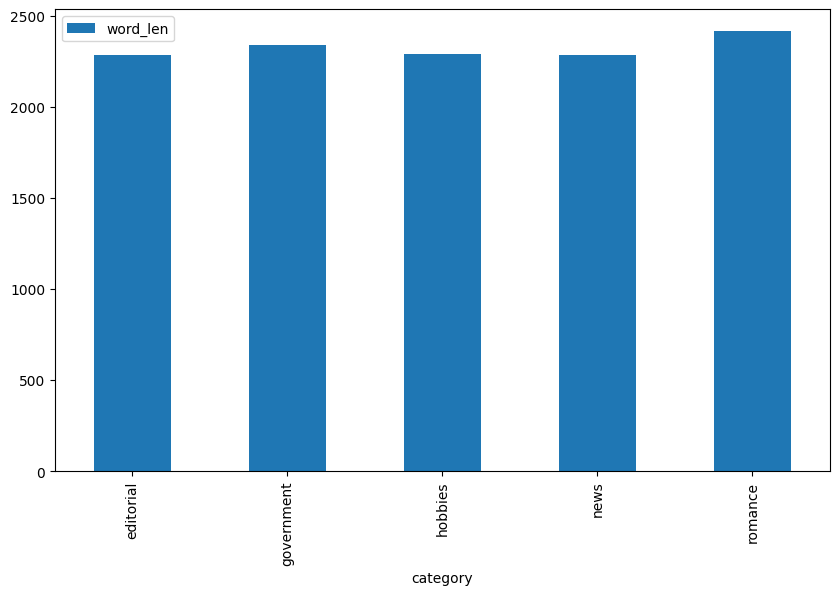

In [13]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [14]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

c:\Users\bista\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [15]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The two data frames 'count_text_vectors' and 'tfidf_text_vectors' are discussed below:

count_text_vectors: This data frame hold the raw word counts for each documents. It represents the term frequency of the corpus. It is simple and records the count of particular word in the corpus.  

tfidf_text_vectors: This data frame hold the TF-IDF scores for each words in each documents. It contains the weighted word frequencies for the words. TF-IDF works with the raw count of word with respect of the words frequency across the entire corpus. If the words is frequent in most of the corpus it will have lower weightage whereas if the words is frequent in few corpus it will have higher weightage. This also explains the importance words for the each documents. 

The shape of the count_text_vectors and tfidf_text_vectors are both (166, 4941). This explains that there are 166 documents (represented as rows) and 4941 unique terms (represented as columns) based on removing stopwords and filtering min_df=5 and max_df=0.7.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [16]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [17]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


topic        0   1   2   3  4
category                     
editorial   20   4   2   0  1
government   4   0  26   0  0
hobbies      0   8  26   1  1
news         8   0  11  17  8
romance      0  29   0   0  0


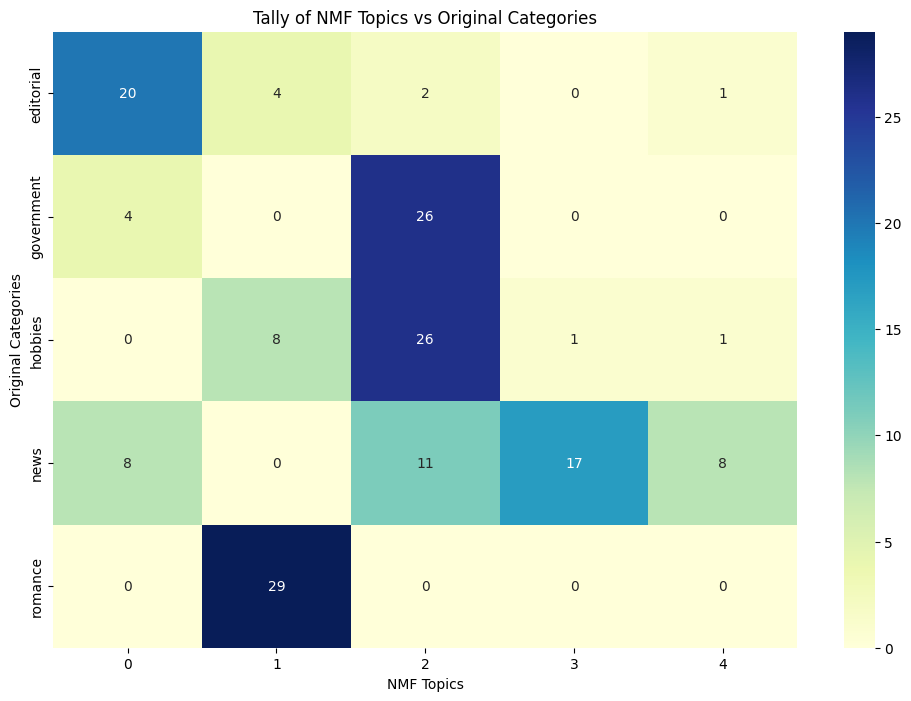

In [19]:
import pandas as pd

df['topic'] = W_text_matrix.argmax(axis=1)

# A new DataFrame to tally counts
tally = df.groupby(['category', 'topic']).size().unstack(fill_value=0)

# Display the tally
print(tally)

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(tally, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Tally of NMF Topics vs Original Categories')
plt.ylabel('Original Categories')
plt.xlabel('NMF Topics')
plt.show()


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: We can compare the five topic model based on the each topics.

Topic 0: This topic is dominated by the editorial category with 20 articles. 
Topic 1: This topic is dominated by romance category with 29 article and editorial category has few 4 articles. 
Topic 2: This topic is domianted by goverment and hobbies categories with 26 articles each. 
Topic 3: This topic is dominated by the news category with 17 articles. 
Topic 4: This topic has low representation in all categories with 8 articles from news , 1 articles from editorial and hobbies. 

Hence, we can observe that Topic 0, 1, 2 and 3 has notable association with various categories. This means there is correaltion between different categories. 
However, Topic 4 has low numbers on all categories. This suggests there needs further investigation as the result is different from the original categories. NMF is very effective in understanding the topical strucutres and this can also aid in the model improvement and enhancing accuracy. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)
Category     0  1  2  3  4
Topic                     
editorial   27  0  0  0  0
government  30  0  0  0  0
news        34  0  0  3  7
romance     21  8  0  0  0
hobbies     36  0  0  0  0


<Axes: xlabel='Topic'>

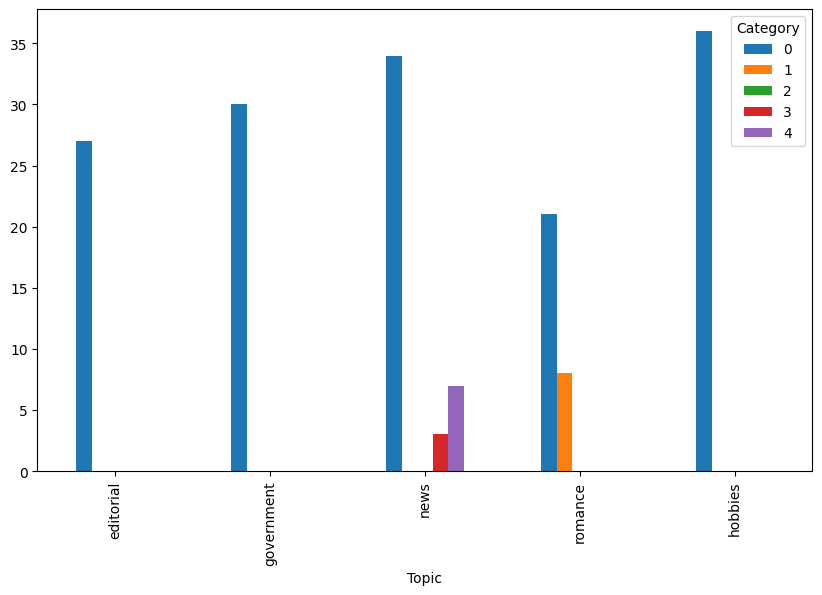

In [20]:

# Fitting an LSA Model (TruncatedSVD)

# Create a TruncatedSVD model for LSA
n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics, random_state=314)
lsa_W_matrix = lsa_model.fit_transform(tfidf_text_vectors)  
lsa_H_matrix = lsa_model.components_

# Function to display topics
def display_lsa_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))

# Display the topics found by the LSA model
display_lsa_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())

# Tally the categories for each topic
topic_categories = {i: defaultdict(int) for i in range(n_topics)}

# Assign each document to the topic it belongs to
for i in range(len(df)):
    topic_index = np.argmax(lsa_W_matrix[i])  
    category = df['category'].iloc[i]
    topic_categories[topic_index][category] += 1

# Convert to DataFrame for better visualization
topic_category_df = pd.DataFrame(topic_categories).fillna(0).astype(int)
topic_category_df.index.name = 'Topic'
topic_category_df.columns.name = 'Category'

# Display the results
print(topic_category_df)

# Plotting the results 
topic_category_df.plot(kind='bar', figsize=(10, 6))


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: Topic 00 shows mixed responses from the categories of government, news, and romance. Topic 01 has the domination of romance with the presence of romantic texts, personal languages, relationship-based texts, etc. These natures are common for romantic characters. Similarly, Topic 02 includes most of the contributions from categories such as editorial, government, and hobbies. Furthermore, Topic 03 is dominated by the hobbies categories. Lastly, Topic 04 includes news categories and more topics of journalism and news reporting. The LSA model captures the categories of hobbies and romance very well but it has some struggles in the categories of editorial, government, and news. 

Q: What is your interpretation of the display topics output? 

A: The display topic output shows the few most frequent and prominent words for the five topics generated by LSA model. The topic 00 has the prominent words as said, mr, mrs, etc. This denotes the simple personal conversations between various subjects. Topic 01 contains words as said, thought, etc. which are related to conservational languages. This can be associated with romance and fictional stories. Topic 2 has words as mrs, mr, kennedy, etc. These are associated with personal recognition. This can be related with editorial and government topics. Topic 3 is dominated by hobby related words as mrs, club, etc. Lastly, topic 04 contains the mix categories of words. This implies that it contains categories of news and government. LSA models does reasonably good with categories like romance and hobbies. However, it tends to mix trends of categories of news and government.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [24]:

from sklearn.decomposition import LatentDirichletAllocation

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_model.fit(count_text_vectors)

# Display the topics from the LDA model
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())

# Prepare for visualization
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

# Visualize the LDA model
pyLDAvis.display(lda_display)



Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: LDS tally output has following conclusions and findings based on different topics. Topic 0 contains the 28 documents in the romance category. Topic 2 has the dominance of government and hobbies with 12 and 9. Topic 2 has the editorial with 21 and news has majority of 32 topics. Topic 3 has the mix of hobbies, government and news. Similarly, topic 4 has the mix of government documents and hobbies. 
In conclusion, romance is dominant on topic 0 and government content is spread across topic 1,2 and 4. Similarly, news is associated with topic 2 and hobbies are spread across topics 0,1,3 and 4. LDA model has properly clustered categories as romance and news. But it gave a mixed association with government and hobbies. 
 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: LDA model and original Brown has some interesting similarities and dissimilarities. In romance categories, LDA and Brown almost perfectly captures the documents. News categories also has been properly captured by LDA. The government categories is divided into topics 1,2 and 4. The editorial is mostly associated with topic 2. The hobbies categories is spread across topic 0,1,3 and 4. LDA model captures most of the themes from Brown corpus. It performs really well for news and romance categories. Other categories such as government, editorial and hobbies are spread across the multiple topics. Hence, even LDA model is struggling to separate some documents cleanly. 

lda_topic    0   1   2  3   4
category                     
editorial    3   1  21  2   0
government   1  12   3  4  10
hobbies     11   9   2  8   6
news         4   3  32  3   2
romance     28   0   1  0   0


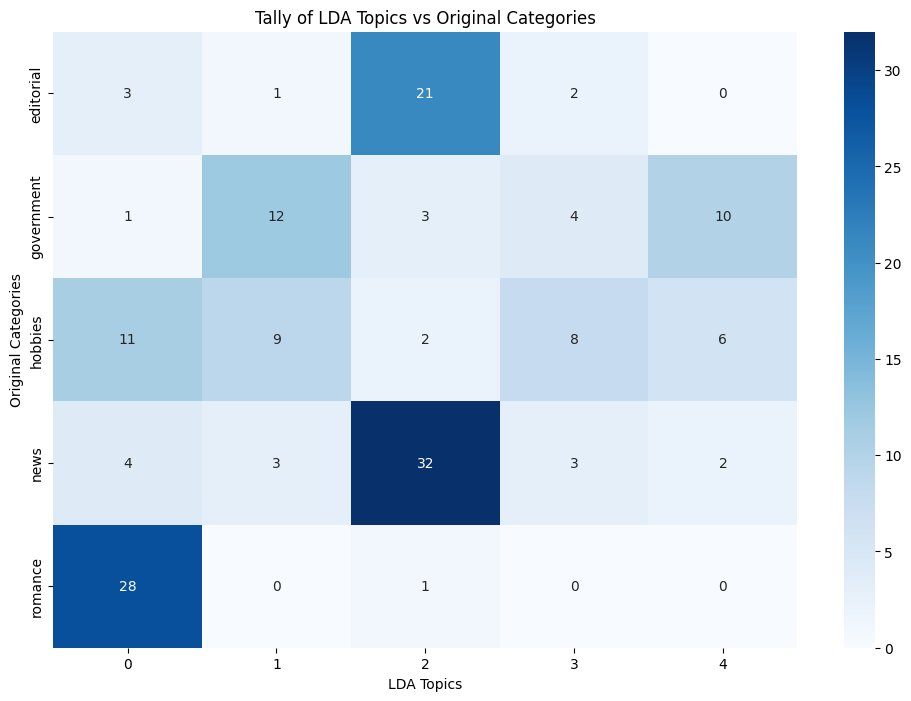

In [28]:

# topics to documents
df['lda_topic'] = lda_model.transform(count_text_vectors).argmax(axis=1)

# Create a new DataFrame to tally counts
lda_tally = df.groupby(['category', 'lda_topic']).size().unstack(fill_value=0)

# Display the tally
print(lda_tally)

# A visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(lda_tally, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Tally of LDA Topics vs Original Categories')
plt.ylabel('Original Categories')
plt.xlabel('LDA Topics')
plt.show()


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The visualization above can be divided into two parts as Intertopic distance map(scatterplot) and top 30 most salient terms graph. 

The intertopic distance map provides the visuals of the topic separation and bubble size. The scatterplot is created after performing the principal component analysis and dimensionality reduction. The topics such as 2,3 and 4 are clustered together as they have similarities or correlation between them. However, topic 1 is placed separately from the rest topics. This explains the uniqueness and poor correlation between topic 1 and other topics. The bubble size is related proportion of document for the different topics. Topic 3 has the largest bubble size which implies the large dataset of documents. Similarly, the small size of topic 1 imply small dataset of documents. 

In this portion of the graph, the top 30 salient terms are captured. The common terms, term frequency and topical relevance are recorded for the visualization. Some of the common terms were state, states, said, mrs, development, etc. Likewise, the terms state and said has highest repetition throughout the corpus. A parameter is also defined in the graph providing the insight between the high frequency and significant features in the various topic categories.  

Some of the key insights from the visualization are the nature of the various topics. The topic 1 is highly distinct from another topic suggesting the unique theme. However, topics 2,3, 4 and 5 have more similarities. This implies the interrelation between the topics. There are also some terms are said, state, etc. which are more frequent and influential.  These terms are related to large corpus documents and multiple topics. 



## References

OpenAI. (2024). ChatGPT (October 8 version) [Large language model]. https://chat.openai.com/
